In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
with open('tom_1.txt', 'r') as f:
    text = f.read().lower()
text = re.sub('[^а-я ]','', text)

In [4]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [5]:
POS['а']

0

In [6]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [7]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [8]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [9]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

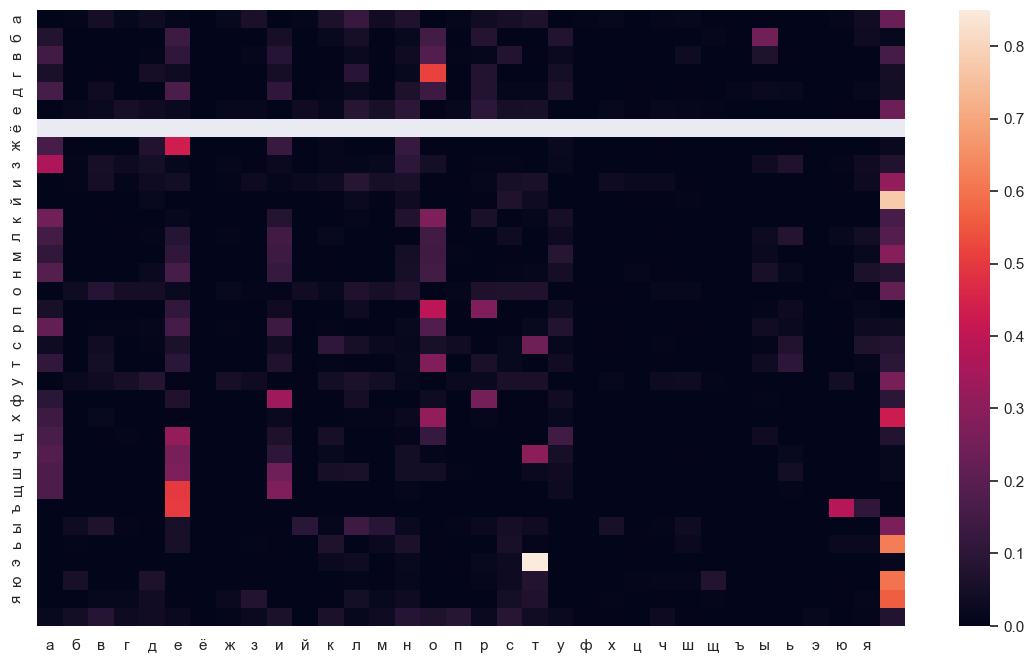

In [10]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

In [11]:
string = "это"
proba = 1.0 / 33
for cp, cn in zip(string[1:], string[:-1]):
    proba *= probabilities[POS[cp], POS[cn]]
print(proba)

4.155891922333243e-07


Посчитаем вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р» (с учетом пробелов)

In [12]:
start = POS['п']
end = POS['р']
k = 0
prior = 1. / (len(RUSSIAN) - 1)
df = pd.DataFrame(columns = ['word', 'probability'])
for i in RUSSIAN:
    for j in RUSSIAN:
        proba = prior * probabilities[start, POS[i]] * probabilities[POS[i], POS[j]] * probabilities[POS[i], end]
        if proba > 0:
            if k % 100 == 0:
                print(''.join(['п', i, j, 'р']), proba)
            to_append = [''.join(['п', i, j, 'р']), proba]
            df_length = len(df)
            df.loc[df_length] = to_append
            k += 1

паар 1.5061351793705292e-08
пифр 3.8557739002474914e-09
ппнр 7.302437158963524e-08
птчр 1.3418806154520816e-08
пымр 5.401362571196906e-07
п ор 7.36511756949955e-08


Выведем топ-10 наиболее вероятных строк:

In [13]:
df.sort_values(by=['probability'], ascending=False).head(10)

,word,probability
193,по р,0.000166
79,пе р,0.000081
166,повр,0.000065
175,полр,0.000054
177,понр,0.000054
182,потр,0.000054
181,поср,0.000052
180,порр,0.000050
176,помр,0.000039
167,погр,0.000037


Используя матрицу переходных вероятностей, сгенерируем слово, начинающееся с буквы «Б» длиной восемь символов (без учета б)

In [14]:
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    print(POS[s[i]], s[i])
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print(''.join(s))

1 б
9 и
18 с
11 к
15 о
33  
2 в
8 з
биско вза


Оценим ряд через HMM и сделаем наивный прогноз

In [15]:
from hmmlearn.hmm import GaussianHMM
series = pd.read_csv("international-airline-passengers.csv")['Count']

In [16]:
values = pd.DataFrame(series.values.reshape(-1,1))

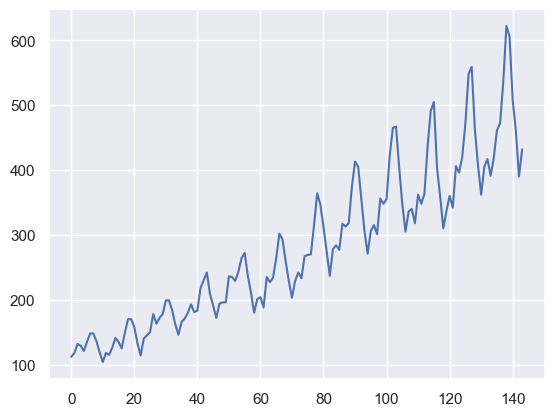

In [17]:
plt.plot(values)

In [31]:
for n in range(3, 15):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag")
    model.fit(values)
    print(n, model.score(values))

Fitting a model with 167 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 144 data points will result in a degenerate solution.
Fitting a model with 223 free scalar parameters with only 144 data points will result in a degenerate solution.


3 -781.5480352158934
4 -772.8023949764561
5 -782.2683791343367
6 -741.2376059349372
7 -770.8995252811027
8 -754.6589930876057
9 -756.45209165786
10 -742.6236688386042
11 -707.7741684289907
12 -698.3223828855763
13 -712.8912617372722
14 -680.0186632109582


Fitting a model with 223 free scalar parameters with only 144 data points will result in a degenerate solution.


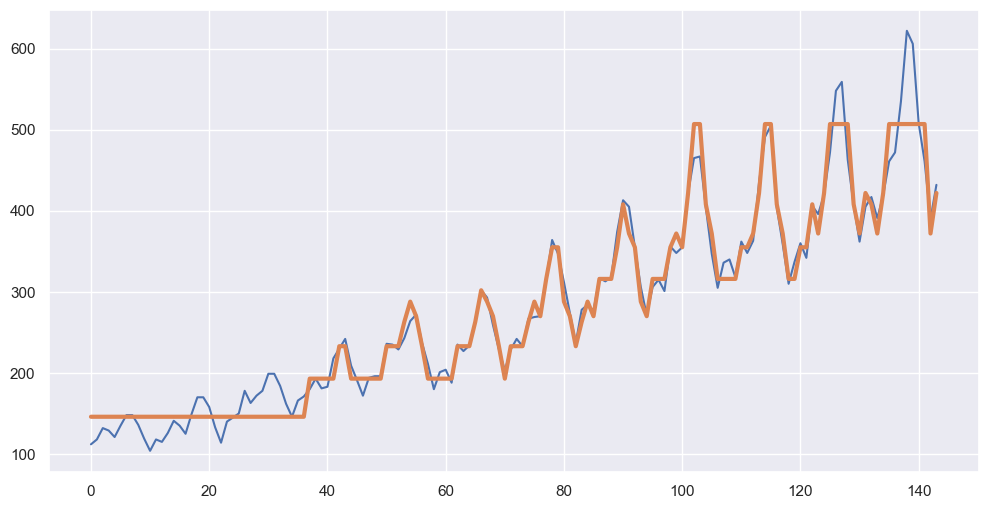

In [32]:
model = GaussianHMM(n_components=14,
                    covariance_type="diag",
                    n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [33]:
model.transmat_.shape

(14, 14)

In [34]:
series = np.array(series)
X = series.reshape(-1, 1)

In [35]:
model2 = GaussianHMM(n_components=14,
                    covariance_type="diag",
                    n_iter=1000)
model2.fit(X)

Fitting a model with 223 free scalar parameters with only 144 data points will result in a degenerate solution.


GaussianHMM(n_components=14, n_iter=1000)

In [36]:
future_steps = 10 
predicted_values, _ = model.sample(n_samples=future_steps)

In [37]:
print("Прогнозируемые значения:", predicted_values.flatten())

Прогнозируемые значения: [135.970417   150.86709056 179.01776211 230.18329427 234.84862245
 256.5533562  285.7469822  274.77846081 231.10832484 187.15512849]


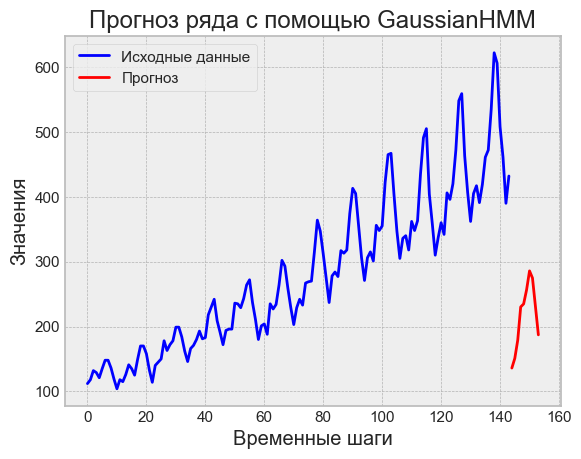

In [38]:
with plt.style.context('bmh'):
    plt.plot(X, label='Исходные данные', color='blue')
    plt.plot(np.arange(len(X), len(X) + future_steps), predicted_values, label='Прогноз', color='red')
    plt.xlabel('Временные шаги')
    plt.ylabel('Значения')
    plt.title('Прогноз ряда с помощью GaussianHMM')
    plt.legend()
    plt.show()

Как можно заметить это не лучшая модель для предсказания, плюс у нашего ряда есть тренд, а hmm не работает с трендами

Прогнозирование следующего значения через среднее каждой компоненты:

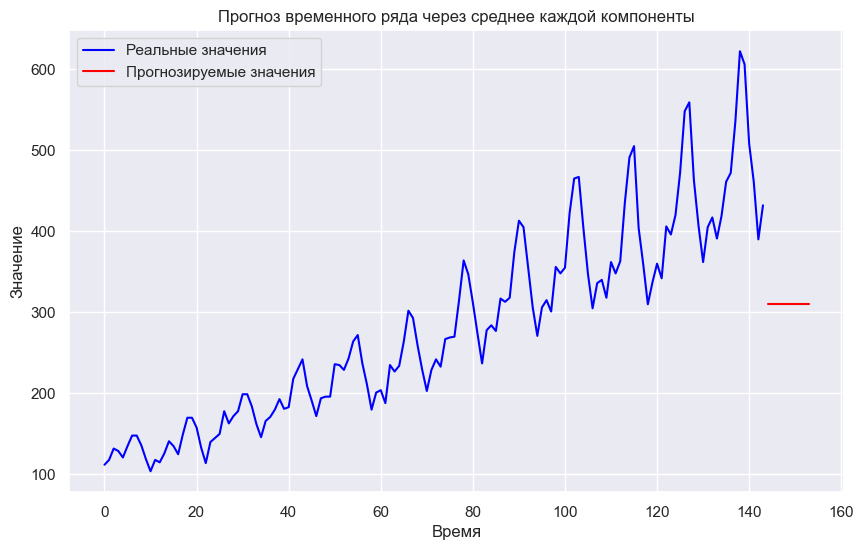

In [40]:
# Получение средних значений каждой компоненты
means = model.means_

future_steps = 10
predicted_values = []
for _ in range(future_steps):
    next_observation = np.mean(means)
    predicted_values.append(next_observation)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(series, label='Реальные значения', color='blue')
plt.plot(range(len(series), len(series) + future_steps), predicted_values, label='Прогнозируемые значения', color='red')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Прогноз временного ряда через среднее каждой компоненты')
plt.legend()
plt.show()
